In [4]:
from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA
import math
def RK4(H0, mu, Vint, gamma, D, h, t, tau):
    k1 = np.zeros_like(D)
    k2 = np.zeros_like(D)
    k3 = np.zeros_like(D)
    k4 = np.zeros_like(D)
    D1 = np.zeros_like(D)
    D2 = np.zeros_like(D)
    D3 = np.zeros_like(D)
    D4 = np.zeros_like(D)
    Df = np.zeros_like(D)
    
    ### Get k1
    H1 = H0 - EField(t, tau)*mu + Vint
    D1 = np.copy(D)    
    k1 = h*Liouville(H1,D1) + h*Lindblad(D1, gamma)
    
    ## Update H and D and get k2
    H2 = H0 - EField(t+h/2, tau)*mu + Vint
    D2 = D+k1/2.
    k2 = h*Liouville(H2, D2) + h*Lindblad(D2, gamma)
    
    ### UPdate H and D and get k3
    H3 = H2
    D3 = D+k2/2
    k3 = h*Liouville(H3, D3) + h*Lindblad(D3, gamma) 
    
    ### Update H and D and get K4
    H4 = H0 - EField(t+h, tau)*mu + Vint
    D4 = D+k3
    k4 = h*Liouville(H4, D4) + h*Lindblad(D4, gamma)
    
    Df = D + (1/6.)*(k1 + 2.*k2 + 2*k3 + k4)
    return Df

def Lindblad(D, gamma):
    dim = len(D)
    LD = np.zeros_like(D)
    ### need |g><g|
    bra_1 = CreateBas(dim, 0)
    gm = Form_Rho(bra_1)
    
    for k in range(1,dim):
        bra_k = CreateBas(dim, k)
        km = Form_Rho(bra_k)
        
        ### first term 2*gam*<k|D|k>|g><g|
        t1 = 2*gamma*D[k][k]*gm
        ### second term is |k><k|*D
        t2 = np.dot(km,D)
        ### third term is  D*|k><k|
        t3 = np.dot(D, km)
        LD = LD + t1 - gamma*t2 - gamma*t3
        
    return LD

### Take commutator of H and D to give Ddot
def Liouville(H, D):
    ci = 0.+1j
    return -ci*(np.dot(H,D) - np.dot(D, H))

def EField(t, tau):
    Ef = 0.
    if t<tau:
        Ef = 0.0001*np.sin(t*np.pi/tau)*np.sin(t*np.pi/tau)*np.sin(0.07423*t)
    
    #Ef = 0.00001*np.sin(0.1192*t)
    #Ef = 0.
    #if t<tau:
    #    Ef = 0.001*np.sin(t*np.pi/tau)*np.sin(t*np.pi/tau)*np.sin(0.1192*t)
    return Ef

def Form_Rho(Psi):

    D = np.outer(Psi,np.conj(Psi))
    return D

### Creates basis vector for state k
### k=0 -> ground state, k=1 -> first excited-state, etc
def CreateBas(dim, k):
    bas = np.zeros(dim)
    bas[k] = 1
    return bas



In [5]:
dt = 0.01
tau = 50.
#gamma = 0.0017
gamma = 0.005512
eps0 = 8.854e-12
mu_au_to_si = 8.47835326e-30
E_au_to_si = 5.14220652e11

#mu_z = 58.
mu_z = 176.356700
MUZ= np.zeros((2,2),dtype=complex)
Vint = np.zeros((2,2),dtype=complex)
D = np.zeros((2,2),dtype=complex)
H0 = np.zeros((2,2))

#H0[1][1] = 0.1275
H0[1][1] = 0.075042
D[0][0] = 1.+0j
MUZ[0][1] = mu_z
MUZ[1][0] = mu_z

Nsteps = 1000000
ez = np.zeros(Nsteps)
mu_of_t = np.zeros(Nsteps,dtype=complex)
time = np.zeros(Nsteps)
energy = np.zeros(Nsteps)



for i in range(0,Nsteps):
    energy[i] = np.pi*2*(i+1)/(Nsteps*dt)
    time[i] = i*dt
    ez[i] = EField(i*dt, tau)*E_au_to_si
    D = RK4(H0, MUZ, Vint, gamma, D, dt, dt*i, tau)
    DMU = np.matmul(D, MUZ)
    mu_of_t[i] = (DMU[0][0] + DMU[1][1])*mu_au_to_si


#mu_freq = np.fft.fft(mu_of_t)/(Nsteps)
#ez_freq = np.fft.fft(ez)/(Nsteps)
#alpha = mu_freq/ez_freq
#alpha = np.fft.fft(mu_of_t)/np.fft.fft(ez)
#lam = 1e-9*1240/(energy*27.211) ### in nm

#sigma = 2*np.pi/(lam*eps0) * np.imag(alpha)
#plt.plot(energy*27.211, sigma, 'red')
#plt.plot(1240/(sphere.lambda_array*1e9), sigma_abs, 'b--')
#plt.xlim(1.5,4.0)
#plt.ylim(0,1e-16)
#plt.plot(time, ez, 'red', time, mu_of_t, 'blue')
#plt.show()


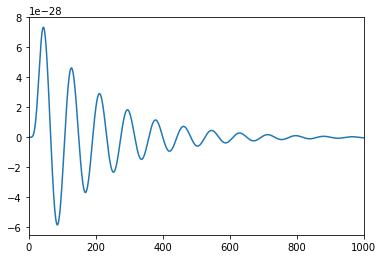

In [25]:
### omega below will be in atomic units... use this to convert to SI units (i.e. s^-1)
omega_au = 4.134147e+16
plt.plot(time, mu_of_t)
plt.xlim(0,1000)
plt.show()
dipole = np.zeros(2*Nsteps,dtype=complex)
efield = np.zeros(2*Nsteps,dtype=complex)
nps = np.zeros(2*Nsteps,dtype=complex)
efs = np.zeros(2*Nsteps,dtype=complex)
ome = np.zeros(2*Nsteps)
alpha = np.zeros(2*Nsteps,dtype=complex)
sigma_abs = np.zeros(2*Nsteps)
for i in range(0,Nsteps):
    dipole[i] = mu_of_t[i]
    efield[i] = ez[i]

for i in range(0,2*Nsteps):
    ome[i] = 2*np.pi*i/(2*Nsteps*dt)
    

In [27]:


nps = np.fft.fft(dipole)
efs = np.fft.fft(efield)
for i in range(0,2*Nsteps):
    omega_si = ome[i]*omega_au
    k = omega_si/2.99792458e+8
    sig_pre = k/(8.854187e-12)
    alpha[i] = nps[i]/efs[i]
    sigma_abs[i] = sig_pre * np.imag(alpha[i])
#ez_freq = np.fft.fft(ez)/(Nsteps)

(0, 1e-16)

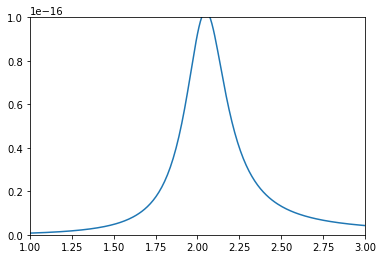

In [32]:
plt.plot(ome*27.211, -1*sigma_abs)
plt.xlim(1,3)
plt.ylim(0,1e-16)